# Imports

In [27]:
# Cell 1: Imports and Setup
import os
import glob
import pandas as pd
import numpy as np
import torch
import optuna
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from models.kan import KANClassifier
from scipy.stats import ks_2samp
from scikit_plotting import plot_model_performance

RANDOM_STATE = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
N_TRIALS = 20
DATA_DIR = os.path.join(os.getcwd(), 'data')

print(f"Running on device: {DEVICE}")

Running on device: cuda


In [28]:
# Cell 2: Load Dataset
if not os.path.exists(DATA_DIR):
    csv_path = 'customer_churn_telecom_services.csv'
else:
    csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    csv_path = csv_files[0] if csv_files else 'customer_churn_telecom_services.csv'

print(f"Loading dataset: {csv_path}")
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print("CSV not found! Place it in 'data' or project root.")
    raise

print('Shape:', df.shape)

Loading dataset: c:\Users\j.guimaraes.pontes\churn-predict\data\customer_churn_telecom_services.csv
Shape: (7043, 20)


# Pré-processamento dos dados

In [29]:
# Cell 3: Cleaning & Preprocessing
target_col = "Churn"

def to_binary(series):
    if series.dtype == 'O':
        return series.str.lower().map({
            'yes':1,'sim':1,'true':1,'y':1,'1':1,
            'no':0,'nao':0,'false':0,'n':0,'0':0
        }).fillna(series)
    return series

df[target_col] = to_binary(df[target_col])

# Clean TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)

# Separate X and y
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# Identify columns
categorical_cols = [c for c in X.columns if X[c].dtype == 'O']
numeric_cols = [c for c in X.columns if c not in categorical_cols]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Process all data before split
print("Processing data...")
X_processed = preprocessor.fit_transform(X)

Processing data...


In [30]:
# Cell 4: Split 50/25/25 e SMOTE no Treino e Validação

# Split 1: 25% para teste final
X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
# Split 2: 25% do original para validação (0.3333 de 75%) e 50% para treino
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.3333, random_state=RANDOM_STATE, stratify=y_temp
)

print(f"Shapes Originais: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

smote = SMOTE(random_state=RANDOM_STATE)

# SMOTE no Treino
print("Applying SMOTE on Train...")
try:
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    print(f"Train - Antes: {np.bincount(y_train)} | Depois: {np.bincount(y_train_bal)}")
except Exception as e:
    print(f"SMOTE no treino falhou: {e}")
    X_train_bal, y_train_bal = X_train, y_train

# SMOTE na Validação
print("Applying SMOTE on Validation...")
try:
    X_val_bal, y_val_bal = smote.fit_resample(X_val, y_val)
    print(f"Val - Antes: {np.bincount(y_val)} | Depois: {np.bincount(y_val_bal)}")
except Exception as e:
    print(f"SMOTE na validação falhou: {e}")
    X_val_bal, y_val_bal = X_val, y_val

Shapes Originais: Train=(3516, 45), Val=(1758, 45), Test=(1758, 45)
Applying SMOTE on Train...
Train - Antes: [2581  935] | Depois: [2581 2581]
Applying SMOTE on Validation...
Val - Antes: [1291  467] | Depois: [1291 1291]


# Treinamento com KAN

 Optuna – KAN com KS

Nesta etapa, o Optuna é utilizado para otimizar os hiperparâmetros do modelo **KAN**
tendo a **estatística KS** como métrica-alvo. O modelo é treinado no conjunto de
**treino balanceado** e avaliado na **validação balanceada**, sem acesso ao teste.

A escolha do KS prioriza configurações com melhor **separação entre churners e
não churners**, métrica especialmente relevante para problemas de churn e tomada
de decisão baseada em ranking.


In [31]:
def ks_metric(y_true, y_score):
    return ks_2samp(
        y_score[y_true == 1],
        y_score[y_true == 0]
    ).statistic


In [32]:
# Cell 5: Optuna Optimization for KAN (KS como métrica alvo)

from scipy.stats import ks_2samp

def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_size = trial.suggest_categorical('hidden_size', [16, 32, 64])
    hidden_sizes = tuple([hidden_size] * n_layers)

    grid_size = trial.suggest_int('grid_size', 3, 8)
    spline_order = trial.suggest_int('spline_order', 2, 3)

    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)

    model = KANClassifier(
        hidden_sizes=hidden_sizes,
        grid_size=grid_size,
        spline_order=spline_order,
        learning_rate=lr,
        weight_decay=weight_decay,
        batch_size=batch_size,
        max_epochs=20,
        device=DEVICE
    )

    model.fit(X_train_bal, y_train_bal)

    probs_val = model.predict_proba(X_val_bal)[:, 1]

    try:
        ks = ks_2samp(
            probs_val[y_val_bal == 1],
            probs_val[y_val_bal == 0]
        ).statistic
        return ks
    except ValueError:
        return 0.0


print("\nStarting Optuna search...")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

print("\nBest params:")
print(study.best_params)


Starting Optuna search...

Best params:
{'n_layers': 1, 'hidden_size': 16, 'grid_size': 4, 'spline_order': 2, 'lr': 0.004761070858391009, 'batch_size': 64, 'weight_decay': 1.955862685235769e-05}


A busca de hiperparâmetros com **Optuna** para o modelo **KAN (Kolmogorov–Arnold Networks)** identificou a seguinte configuração ótima, maximizando o desempenho no conjunto de validação:

 Melhores Hiperparâmetros Encontrados

- **`n_layers`**: 1  
- **`hidden_size`**: 16  
- **`grid_size`**: 4  
- **`spline_order`**: 2  
- **`learning_rate`**: ~4.76e-3  
- **`batch_size`**: 64  
- **`weight_decay`**: ~2.0e-5 


Final Test Results:
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1291
           1       0.54      0.74      0.62       467

    accuracy                           0.76      1758
   macro avg       0.71      0.75      0.72      1758
weighted avg       0.80      0.76      0.77      1758

AUROC Final: 0.8328
KS Statistic: 0.5155, p-value: 0.0000


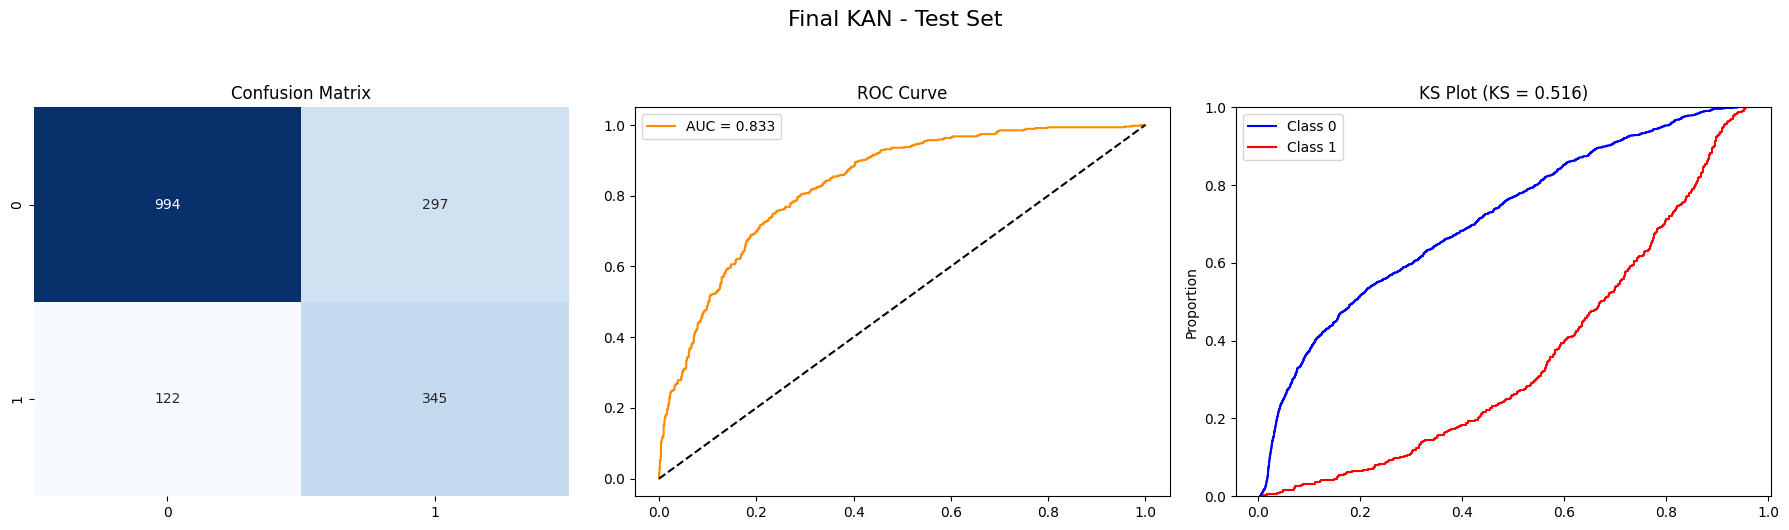

In [33]:
# Cell 6: Final Training and Test Evaluation
best_params = study.best_params
best_hidden_sizes = tuple([best_params['hidden_size']] * best_params['n_layers'])

final_model = KANClassifier(
    hidden_sizes=best_hidden_sizes,
    grid_size=best_params['grid_size'],
    spline_order=best_params['spline_order'],
    learning_rate=best_params['lr'],
    weight_decay=best_params['weight_decay'],
    batch_size=best_params['batch_size'],
    max_epochs=50,
    device=DEVICE
)

final_model.fit(X_train_bal, y_train_bal)

print("\nFinal Test Results:")
probs_test = final_model.predict_proba(X_test)[:, 1]
preds_test = (probs_test >= 0.5).astype(int)

print(classification_report(y_test, preds_test))
print(f"AUROC Final: {roc_auc_score(y_test, probs_test):.4f}")
ks_statistic, ks_pvalue = ks_2samp(probs_test[y_test == 1], probs_test[y_test == 0])
print(f"KS Statistic: {ks_statistic:.4f}, p-value: {ks_pvalue:.4f}")
plot_model_performance(final_model, X_test, y_test, title="Final KAN - Test Set")

### Avaliação Final no Conjunto de Teste (Otimização por KS)

O modelo KAN otimizado com base na estatística KS apresentou desempenho sólido no
conjunto de teste, com **AUROC ≈ 0.83** e **KS ≈ 0.52**, indicando forte capacidade
de separação entre clientes churners e não churners.

A otimização por KS resultou em um **aumento significativo do recall da classe
positiva (~0.74)**, reduzindo a quantidade de churns não identificados, ao custo
de uma menor precisão. Esse trade-off é esperado e desejável no contexto de churn,
onde falsos negativos representam maior impacto financeiro do que falsos positivos.

Os resultados são consistentes com a validação e reforçam a adequação do modelo
para apoiar estratégias de retenção, sem indícios de vazamento de dados ou
overfitting relevante.
